<a href="https://colab.research.google.com/github/David-BA-LMO/RoBERTa-fine_tunning_sentiment_analysis/blob/main/An%C3%A1lisis_de_Sentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Afinado de RoBERTa para análisis de sentimientos**


En este cuaderno procederemos al afinamiento de un modelo de lenguaje RoBERTa (*Robustly Optimized BERT Pretraining Approach*), basado en el revolucionario BERT de Google, un transformer codificador. De la misma manera que su predecesor, RoBERTa es un modelo pre-entrenado por enmascaramiento: de forma aletoria ciertos tokens en el texto de entrada son ocultado o enmascarados, siendo tarea del modelo la predicción correcta de ellos haciendo uso del contexto bidireccional. Tras esta etapa se procede al afinamiento, un conjunto de tareas algo más especializadas relacionadas con la clasificación y selección de texto. RoBERTa incorpora algunas mejoras respecto a este esquema inicial de BERT, principalmente relacionadas con la optimización de hiperparámetros y la cantidad de datos de entrenamiento, del orden de diez veces más que en BERT.


Una de las tareas de afinado que son relevantes para el objetivo de esta práctica es la clasificación de textos. Para ello se hace uso de un token especial que es insertado a todos los inputs textuales que alimentan el modelo, normalmente situado en la primera posición. En virtud de la multiplicación matricial que supone el mecanismo de auto-atención, fundamento de la aqrquitectura transformer, dicho token (denotado como [CLS]) recoge información del resto de tokens de entrada. Así, una vez procesado secuencialmente por los diferentes módulos de la red, es únicamente el token [CLS] el que se utiliza en la clasificación final del modelo. Para ello se le hace pasar por una capa lineal densamente conectada, seguida de una función softmax, la cual devolverá una probabilidad para cada una de las *labels* (clases) en nuestro dataset. En esta práctica hacemos uso de una clasificación binaria, por lo que contamos con dos labels: 0 y 1.


Antes de proceder al afinado de RoBERTa se realizará un tratamiento del texto de entrenamiento que explicaremos más adelante. El modelo será accedido a través del repositorio HuggingFace. El tratamiento de los datos, así como su carga y la definición del modelo se realizará con PyTorch Lightning, una biblioteca pensada para operar de forma modular con redes neuronales.

Link al repositorio de RoBERTa en HuggingFace: https://huggingface.co/FacebookAI/roberta-base

Link al paper original de RoBERTa: https://arxiv.org/abs/1907.11692

# **Análisis del dataset**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

url='https://drive.google.com/file/d/1_f7FrqBlMR5j4jUdf4nl7FguBW5-6DV5/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url)

data.head(6)

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1
5,5,637692793083817985,Sat Aug 29 18:26:24 +0000 2015,Making packing lists is my new hobby... #movin...,1013187241,84,211,251,837,1,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [3]:
data.drop(data.columns[:2], axis=1, inplace=True)
data.drop("user_id", axis=1, inplace=True)

In [4]:
data["post_created"]=data["post_created"].apply(pd.to_datetime)
data["month"]=data["post_created"].dt.month
data["year"]=data["post_created"].dt.year
data.drop("post_created", axis=1, inplace=True)

data.head()

,post_text,followers,friends,favourites,statuses,retweets,label,month,year
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1,8,2015
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1,8,2015
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1,8,2015
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1,8,2015
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1,8,2015


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
followers,20000.0,900.48395,1899.913961,0.0,177.0,476.0,1197.0,28614.0
friends,20000.0,782.42875,1834.817945,0.0,211.0,561.0,701.0,28514.0
favourites,20000.0,6398.23555,8393.072914,0.0,243.0,2752.0,8229.0,39008.0
statuses,20000.0,44394.41960,140778.519201,3.0,5129.0,13251.0,52892.0,1063601.0
retweets,20000.0,1437.92730,15119.665118,0.0,0.0,0.0,1.0,839540.0
label,20000.0,0.50000,0.500013,0.0,0.0,0.5,1.0,1.0
month,20000.0,6.71135,4.735351,1.0,1.0,8.0,12.0,12.0
year,20000.0,2015.48595,1.485434,2009.0,2015.0,2016.0,2016.0,2017.0


In [6]:
data.describe(include="object").T

,count,unique,top,freq
post_text,20000,19488,Oh crap! It's a trap! Aleph took damage.,15


In [7]:
data.drop_duplicates(subset='post_text',inplace=True)

In [8]:
data.dropna()
data.isnull().sum()

,0
post_text,0
followers,0
friends,0
favourites,0
statuses,0
retweets,0
label,0
month,0
year,0


In [9]:
number_columns = data.select_dtypes(["number"]).columns.tolist()
object_columns = data.select_dtypes(["object"]).columns.tolist()

In [10]:
print(data[data["label"]==1].shape[0])
print(data[data["label"]==0].shape[0])

9918
9570


Como vemos, las clases están bastante compensadas con un número de registros muy similar en ambas labels.

# **Preprocesado de texto**

Este preprocesado de texto tiene la finalidad de preparar los datos de entrada antes del afinado del modelo. Dado que se tratan de tweets, es importante eliminar caracteres y términos que podrían resultar superfluos o incluso dañinos en la tarea de clasificación que tenemos en mente. Además se procede a la eliminación de *stopwords* (palabras sin valor semántico significativo) y la *lematización* (reducción de las pabras a su lema), técnicas comunes en el preprocesamiento de texto.

In [11]:
import logging
import nltk
logging.getLogger('nltk').setLevel(logging.ERROR)
nltk.download('stopwords', quiet=True)

True

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob, Word
nltk.download("stopwords")

# LIMPIEZA DE TEXTO
def clean_text(text:str) -> str:
    """
    Realiza una limpieza general de una cadena de texto.
    Parámetros:
      -text: cadena de testo a formatear.
    Devuelve:
      cadena de texto formateada
    """
    # Eliminación de correos electrónicos
    text = re.sub(r'\S+@\S+', '', text)
    # Eliminación de URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar caracteres que no sean letras o espacios
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Eliminar múltiples espacios
    text = re.sub(r'\s+', ' ', text)
    # Eliminar espacios al principio y al final
    text = text.strip()
    # Convierte en minuculas todo caracter
    text = text.lower()
    return text

#ELIMINACIÓN DE STOPWORDS
def remove_stopwords(text:str, lang:str) -> str:
  """
  Elimina stopwords de una cadena se texto
  Parámetros:
    -text: cadena de testo a formatear.
    -language: idioma de la cadena de texto
  Devuelve:
    cadena de texto formateada
  """
  try:
    # Conjunto de stopwords en inglés
      sw = set(stopwords.words(lang))
  except OSError:
      raise ValueError(f"Stopwords para el idioma '{lang}' no está disponible.")
  return " ".join(x for x in text.split() if x not in sw)

# LEMMATIZACIÓN
def lemmatization(text:str, lang:str) -> str:
  """
  Lematiza las palabras en una cadena se texto
  Parámetros:
    -text: cadena de testo a formatear.
    -language: idioma de la cadena de texto
  Devuelve:
    cadena de texto formateada
  """
  if lang == 'english':
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    return " ".join(Word(word).lemmatize() for word in text.split())
  else:
    raise ValueError(f"Lematización para el idioma '{lang}' no está disponible.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# PREPROCESAR TEXTO
def preprocess_text(df: pd.DataFrame, column_name:str, lang='english') -> pd.DataFrame:
  """
  Función de preprocesado de texto para una columna de DataFrame.
  Limpia las cadenas de símbolos y números, elimina stopwords y lematiza las palabras.
  Parámetros:
    -df: DataFrame a revisar
    -column_name: nombre de la columna a formatear.
    -language: idioma de las cadenas de texto de la columnas
  Devuelve:
    cadena de texto formateada
  """
  # Limpiar el texto
  df[column_name] = df[column_name].apply(clean_text)
  # Eliminar stopwords
  df[column_name] = df[column_name].apply(lambda x: remove_stopwords(x, lang))
  # Lematizar el texto
  #df[column_name] = df[column_name].apply(lambda x: lemmatization(x, lang))
  return df

In [14]:
data_preprocesed = preprocess_text(data, "post_text")
data_preprocesed.head()

,post_text,followers,friends,favourites,statuses,retweets,label,month,year
0,years since diagnosed anxiety depression today...,84,211,251,837,0,1,8,2015
1,sunday need break im planning spend little tim...,84,211,251,837,1,1,8,2015
2,awake tired need sleep brain ideas,84,211,251,837,0,1,8,2015
3,rt sewhq retro bears make perfect gifts great ...,84,211,251,837,2,1,8,2015
4,hard say whether packing lists making life eas...,84,211,251,837,1,1,8,2015


# **Visualización**

En esta visualización vemos algunas de los términos (ya preprocesados) más frecuentes, así la distribución de tweets a lo largo de los meses del año, con una clara caída en la temporada veraniega. Estas visualizaciones estan duplicadas para ambas etiquetas. Por último una matriz de correlación en la que observamos escasa correlación entre columnas a excepción "followers"-"friends" y "label"-"year", esto último dandonos a entender que los tweets con label=1 tienden a ser más antiguos.

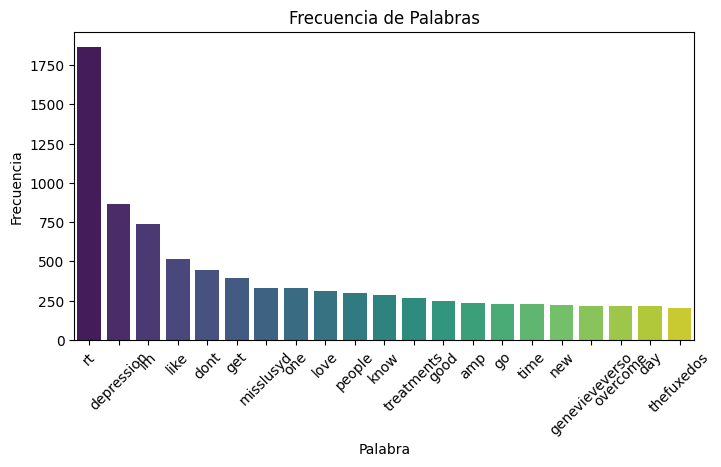

In [15]:
# FRECUENCIA DE TÉRMINOS PARA REGISTROS CON LABEL=1
arrays = []
data_preprocesed[data_preprocesed["label"]==1]["post_text"].apply(lambda x: arrays.append(np.array(x.split())))
word_set = np.concatenate(arrays)
word_series = pd.Series(word_set)
word_frequencies = word_series.value_counts()[:21]

pd_word_frequencies = word_frequencies.reset_index()
pd_word_frequencies.columns = ["word", "frequency"]

plt.figure(figsize=(8, 4))
sns.barplot(x='word', y='frequency', hue='word', legend=False, data=pd_word_frequencies, palette='viridis')
plt.title('Frecuencia de Palabras')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


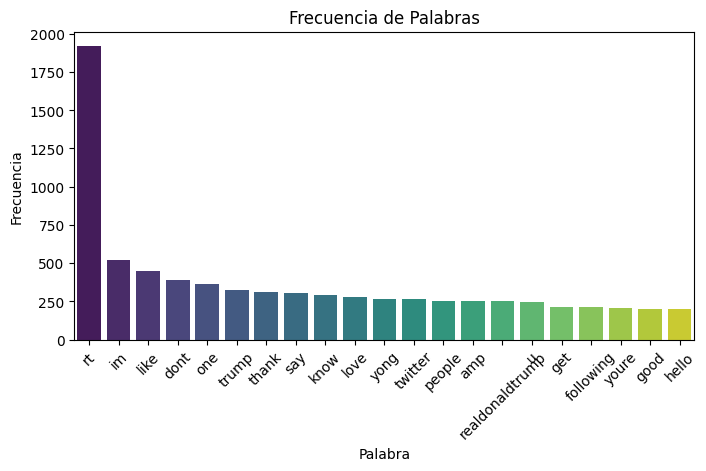

In [16]:
# FRECUENCIA DE TÉRMINOS PARA REGISTROS CON LABEL=0
arrays = []
data_preprocesed[data_preprocesed["label"]==0]["post_text"].apply(lambda x: arrays.append(np.array(x.split())))
word_set = np.concatenate(arrays)
word_series = pd.Series(word_set)
word_frequencies = word_series.value_counts()[:21]

pd_word_frequencies = word_frequencies.reset_index()
pd_word_frequencies.columns = ["word", "frequency"]

plt.figure(figsize=(8, 4))
sns.barplot(x='word', y='frequency', hue='word', legend=False, data=pd_word_frequencies, palette='viridis')
plt.title('Frecuencia de Palabras')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

9918


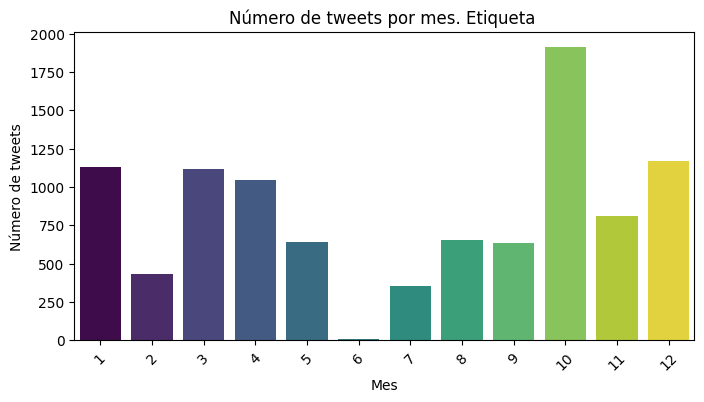

In [17]:
# DISTRIBUCIÓN TEMPORAL DE TWEETS CON LABEL=1
data_per_mont = data_preprocesed.copy()
data_dep_per_month = data_per_mont[data_per_mont["label"]==1].groupby("month").size()
print(data_dep_per_month.sum())
data_dep_per_month = data_dep_per_month.reset_index()
data_dep_per_month.columns = ["month", "number_tweets"]

plt.figure(figsize=(8, 4))
sns.barplot(x='month', y='number_tweets', hue='month', legend=False, data=data_dep_per_month, palette='viridis')
plt.title('Número de tweets por mes. Etiqueta ')
plt.xlabel('Mes')
plt.ylabel('Número de tweets')
plt.xticks(rotation=45)
plt.show()

9570


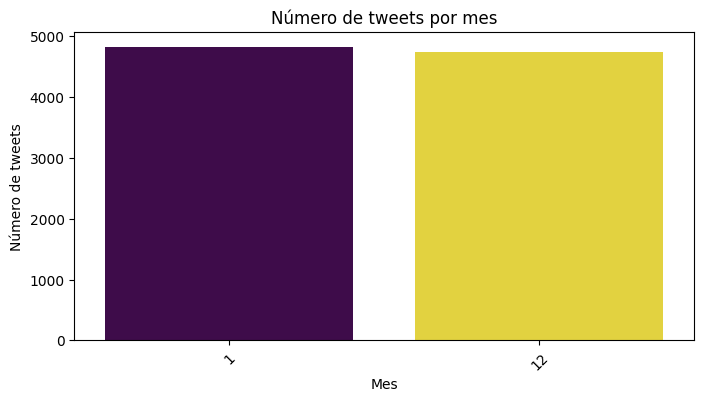

In [18]:
# DISTRIBUCIÓN TEMPORAL DE TWEETS CON LABEL=0
data_no_dep_per_month = data_per_mont[data_per_mont["label"]==0].groupby("month").size()
print(data_no_dep_per_month.sum())
data_no_dep_per_month = data_no_dep_per_month.reset_index()
data_no_dep_per_month.columns = ["month", "number_tweets"]

plt.figure(figsize=(8, 4))
sns.barplot(x='month', y='number_tweets', hue='month', legend=False, data=data_no_dep_per_month, palette='viridis')
plt.title('Número de tweets por mes')
plt.xlabel('Mes')
plt.ylabel('Número de tweets')
plt.xticks(rotation=45)
plt.show()

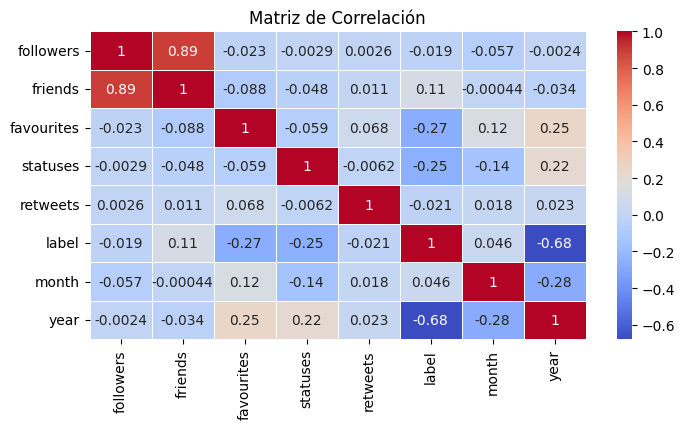

In [19]:
# MATRIZ DE CORRELACIÓN
correlation_matrix = data_preprocesed[number_columns].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# **Dataset para el afinamiento**

El siguiente paso es definir una instancia personalizada de Dataset, una clase de PyTorch cuya tarea es montar la base de datos con la que alimentar el modelo. Evidentemente RoBERTa solo acepta entradas numéricas por lo que un primer paso clave es la **tokenización** de los inputs de entrada. Para ello hacemos uso de `encode_plus()` la cual devuelve un valor numérico, llamado *ID*, para cada token, entendiendo token como cada una de las subcadenas de caracteres en las que es dividido la entrada de texto. Así que, primero la entrada de texto es fragmentada en tokens y luego cada token convertido en un valor numérico, resultando en un vector que llamamos `input_ids`. De forma papalela, para cada entrada se genera un vector de enmascaramiento binario, llamado `attention_mask`. Se trata de un vector del mismo tamaño que su pareja `input_ids` cuyos valores (0 o 1) indican si el token está o no enmascarado. El tamaño máximo de los vectores es de 128 dimensiones tal y como ocurre en la implementación original de RoBERTa, con la posibilidad de rellenar o de truncar si el número de tokens no alcanza o excede respectivamente ese límite. En esta práctica no estamos realizando predicción de tokens por lo que el enmascaramiento simplemente servirá para distinguir tokens reales de los de relleno. La selección del número de dimensiones ha estado mediada por la lóngitud máxima de un tweet y la implementación original de RoBERTa. En resumen, para cada entrada de texto esta clase devuelve su correspondiente `input_ids`, su `attention_mask` y su etiqueta `label`.

Por último también destacamos la inclusión de los tokens especiales de fin [SEP] e inicio [CLS], siendo este último de importancia fundamental en la posterior tarea de clasificación.

In [20]:
from torch.utils.data import Dataset

In [21]:
# PREPARACIÓN DEL DATASET PARA EL MODELO

class Twitter_dep_Dataset(Dataset):

  def __init__(self, df: pd.DataFrame, target_column: str, text_column: str, tokenizer, max_token_len: int = 128):
    self.df = df
    self.target_column = target_column # Columna objetivo (se espera que sea numérica)
    self.text_column = text_column # Columna con el texto
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    self._preprocess_data()

  def _preprocess_data(self):
    self.data = preprocess_text(self.df, self.text_column) # LLamamos a la función que preprocesa el texto

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    """
      Método requerido por el DataLoader de PyTorch. Dataloader selecciona items y __getitem__() los convierte en datos listos para el
      procesamiento por el transformer. Esto es necesario convertir cada instancia en un tensor numérico, acompañado de su etiqueta
      y un máscara.
    """
    # Preparación y tokenización de una instancia del DataFrame por un índice dado.
    item = self.data.iloc[index]
    text = str(item[self.text_column])
    label = int(item[self.target_column])
    # Obtención de los IDs de los tokens (mapeo de subcadenas de texto a enteros). encode_plus() permite además recuperar el tensor de enmascaramiento
    tokens = self.tokenizer.encode_plus(text,
                                        add_special_tokens = True, # Tokens de inicio ([CLS]) y final ([SEP])
                                        return_tensors = 'pt', # Devolver tensores de PyTorch
                                        max_length = self.max_token_len, # Límite de tamaño de los tensores
                                        truncation = True, # Truncar tensores que excede el límite de tokens
                                        padding = 'max_length', # Rellenar tensores que no alcancen el límite de tokens.
                                        return_attention_mask = True # Inlcuir un tensor indicando si los tokens son reales son enmascarados.
                                        )
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'label': label}

# **Carga de datos**

El siguiente paso es definir un `LightningDataModule`, una herramienta que nos permite la carga de los datos en el modelo. De aquí podemos destacar el método `setup()` que divide el dataset en entrenamiento y testeo y los `DataLoader` para cada uno de estos conjuntos.

Otra cosa a destacar es el la definición del algoritmo tokenizador, aquel que despieza el texto de entrada. En este caso simplemente se selecciona el tokenizador específico del modelo a utilizar, que en el caso de RoBERTa es *Byte-Pair Encoding* o codificación por bytes, con un vocabulario inicial de 256 tokens diferentes.

Por último definimos el tamaño del `batch` o número de registros a procesar antes de proceder con el cálculo de la función de pérdida y la actualización de parámetros.


In [22]:
!pip install --q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 52.2 MB/s eta 0:00:00


In [23]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [24]:
# CARGA DE LOS DATOS PARA EL MODELO

class Twitter_dep_Loader(pl.LightningDataModule):

  def __init__(self, df: pd.DataFrame, text_column: str, target_column: str, model_name: str, batch_size: int = 16, max_token_len: int = 128, test_size=0.2):
    super().__init__()
    self.df = df
    self.text_column = text_column
    self.target_column = target_column
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.test_size = test_size
    self.tokenizer = tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
      train_data, test_data = train_test_split(self.df, test_size = self.test_size) # Dividimos el DataFrame en entrenamiento y testeo.
      # Creamos dos objetos DataSet de PyTorch para entrenamiento y testeo.
      self.train_dataset = Twitter_dep_Dataset(train_data, target_column=self.target_column, text_column=self.text_column, tokenizer=self.tokenizer, max_token_len = self.max_token_len)
      self.test_dataset = Twitter_dep_Dataset(test_data, target_column=self.target_column, text_column=self.text_column, tokenizer=self.tokenizer, max_token_len = self.max_token_len)

  def train_dataloader(self):
    # Cargador de datos de entrenamiento
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)

  def test_dataloader(self):
    # Cargador de datos de testeo
    return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

In [25]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# **Creación del modelo**

En esta parte configuramos el modelo a afinar el cual, como ya se ha mencionado, se basa en RoBERTa. Se ha incluido en la sección final una capa lineal seguida de una función de activación ReLU y una capa de clasificación que devuelve logits de salida. A través de estas capas solo discurre le vector del token inicial [CLS] que es el que se utiliza para clasificación. La función de pérdida es la Entropía Cruzada Binaria, típica de tareas de clasificación binaria como es el caso. Como se verá más adelante, el modelo completo conforma entorno a 125 millones de parámetros.



La selección de hiperparámetros ha sido tomada de un modelo ya afinado en el repositorio de HuggingFace especializado en análisis de sentimientos con tweets. Link: https://huggingface.co/AdamLucek/roberta-llama3.1405B-twitter-sentiment/blob/main/training_params.json

In [26]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import torchmetrics

In [35]:
class Twitter_Classifier_model(pl.LightningModule):

    def __init__(self, model_name: str, lr: float):
        super().__init__()
        # Guardar hiperparámetros
        self.save_hyperparameters()
        # Cargamos el modelo desde Hugging Face
        self.pretrained_model = AutoModel.from_pretrained(model_name, return_dict = True) #return_dict=True asegura que las salidas del modelo sean objetos que contienen los diferentes outputs del modelo
        # Capa oculta
        self.hidden_layer = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.activation = nn.ReLU()
        # Capa de salida pensada para clasificación binaria (n_labels=1)
        self.classifier_layer = nn.Linear(self.pretrained_model.config.hidden_size, 1) # config.hidden_size = número de nodos de la última capa del modelo pre-entrenado
        # Inicialización de pesos
        torch.nn.init.xavier_uniform_(self.classifier_layer.weight)
        # Función de pérdida de Entropía Cruzada Binaria para logits.
        self.loss_function = nn.BCEWithLogitsLoss()

        # Métricas de evaluación
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.precision = torchmetrics.Precision(task="binary")
        self.recall = torchmetrics.Recall(task="binary")
        self.f1 = torchmetrics.classification.F1Score(task="binary")
        self.auroc = torchmetrics.classification.F1Score(task="binary")

        # Inicializamos test_outputs
        self.test_outputs = []  # Añadir esta línea para evitar el error

    def forward(self, input_ids, attention_mask, labels=None):
        # Procesamiento de datos a través del modelo
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        # Utiliza la el token CLS (primer token) para la clasificación
        cls_output = output.last_hidden_state[:, 0, :] # Selección de todas las instancias del batch, solo primer token (CLS) y ue sean completos.
        # Pasar por la capa oculta
        cls_output = self.hidden_layer(cls_output)
        cls_output = self.activation(cls_output)
        # Obtención de logits a partir de la capa de clasificación
        logits = self.classifier_layer(cls_output)
        logits = logits.squeeze(-1)  # Esto elimina la dimensión extra, cambiando la forma de [batch_size, 1] a [batch_size]
        # Cálculo de la función de pérdida (en caso de que se indique o no label cuando se realiza el testeo)
        if labels is not None:
            loss = self.loss_function(logits, labels.float())
            return logits, loss
        return logits, None

    # Entrenamiento de cda batch
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label'].float()

        logits, loss = self(input_ids, attention_mask, labels)
        preds = torch.sigmoid(logits)
        preds = torch.round(preds)

        # Métricas de entrenamiento
        self.train_accuracy(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_accuracy, on_epoch=True, prog_bar=True)

        return loss

    # Validación
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label'].float()

        logits, loss = self(input_ids, attention_mask, labels)
        preds = torch.sigmoid(logits)
        preds = torch.round(preds)

        # Métricas de validación
        self.val_accuracy(preds, labels)
        self.precision(preds, labels)
        self.recall(preds, labels)
        self.f1(preds, labels)
        self.auroc(preds, labels)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_accuracy, on_epoch=True, prog_bar=True)
        self.log("val_precision", self.precision, on_epoch=True, prog_bar=True)
        self.log("val_recall", self.recall, on_epoch=True, prog_bar=True)
        self.log("val_f1", self.f1, on_epoch=True, prog_bar=True)
        self.log("val_auroc", self.auroc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label'].float()

        logits, loss = self(input_ids, attention_mask, labels)
        preds = torch.sigmoid(logits)
        preds = torch.round(preds)

        # Métricas de test
        self.test_accuracy(preds, labels)
        self.precision(preds, labels)
        self.recall(preds, labels)
        self.f1(preds, labels)
        self.auroc(preds, labels)

        # Almacenar outputs
        self.test_outputs.append({
            "logits": logits.detach(),
            "labels": labels.detach(),
            "preds": preds.detach()
        })

        return loss

    # Configuración del cálculo de métricas al final de cada época en testeo
    def on_test_epoch_end(self):
        # Calcular métricas finales
        preds = torch.cat([output['preds'] for output in self.test_outputs], dim=0)
        labels = torch.cat([output['labels'] for output in self.test_outputs], dim=0)

        test_accuracy = self.test_accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        f1 = self.f1.compute()
        auroc = self.auroc.compute()

        self.log("test_acc", test_accuracy)
        self.log("test_precision", precision)
        self.log("test_recall", recall)
        self.log("test_f1", f1)
        self.log("test_auroc", auroc)

        # Limpiar outputs al final de la época
        self.test_outputs = []

        # Resetear métricas
        self.test_accuracy.reset()
        self.precision.reset()
        self.recall.reset()
        self.f1.reset()
        self.auroc.reset()

        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        print(f"Test AUROC: {auroc:.4f}")

    def configure_optimizers(self):
      # Optimizadores. Aquí podría haberse incluido un squedule para el ajuste dinámico del learning rate.
      optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
      return optimizer


# **Entrenamiento**

Pasamos a la fase de entrenamiento. Luego instanciamos cada uno de los componentes y entrenamos el modelo. En los modelos tipo BERT el número de épocas o rondas de entrenamiento suelen estar entre 5 y 10, dependiendo la tarea de afinado. Con varias pruebas realizadas se podría decir que el rendimiento suele saturarse a la tercera época. Aun así probamos con 5.

In [41]:
target_column = "label"
text_column = "post_text"
model_name = 'roberta-base' # Indicamos el modelo transformer a utilizar.
learning_rate = 2e-5 # learning rate de acuerdo a las recomendaciones en HuggingFace
num_epochs = 5 # Número de épocas.

In [42]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer

# MODELO
classifier_model = Twitter_Classifier_model(
    model_name=model_name,
    lr=learning_rate
    )

# CARGA DE DATOS
data_loader = Twitter_dep_Loader(
    df=data,
    text_column="post_text",
    target_column="label",
    model_name=model_name)
data_loader.setup()

# ENTRENADOR
trainer = Trainer(
    max_epochs= num_epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu', # En caso de disponer de GPU
    devices=1,
    enable_progress_bar = True  # Barra de progreso
)

# Entrenar el modelo
trainer.fit(classifier_model, datamodule = data_loader)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name             | Type              | Params | Mode 
----------------------------------------------------------------
0  | pretrained_model | RobertaModel      | 124 M  | eval 
1  | hidden_layer     | Linear            | 590 K  | train
2  | activation       | ReLU              | 0      | train
3  | classifier_layer | Linear  

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# **Evaluación**

In [43]:
test_result = trainer.test(classifier_model, datamodule = data_loader)
print(test_result)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 0.9743
Test Precision: 0.9741
Test Recall: 0.9761
Test F1 Score: 0.9751
Test AUROC: 0.9751


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9743458032608032     │
│        test_auroc         │    0.9750996232032776     │
│          test_f1          │    0.9750996232032776     │
│      test_precision       │    0.9741293787956238     │
│        test_recall        │    0.9760717749595642     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9743458032608032, 'test_precision': 0.9741293787956238, 'test_recall': 0.9760717749595642, 'test_f1': 0.9750996232032776, 'test_auroc': 0.9750996232032776}]


# **Entrenamiento y Evaluación de DistillRoBERTa**

Por comparación haremos uso de una versión "destilada" de RoBERTa, DistilRoBERTa, cuya arquitectura es similar a esta pero con menos capas (de 12 a 6) y por tanto requiere de menor tiempo y recursos computacionales. Más adelante compararemos los resultados. En este caso hablaríamos de un modelo de algo más de 82 millones de parámetros. Hay que tener en cuenta que gran parte de estos parámetros pertenecen al algoritmo de *embedding* que es común a ambos modelos. Mantenemos el número de épocas para hacer comparaciones.

In [46]:
model_name_light = 'distilroberta-base' # Indicamos el modelo transformer a utilizar.
num_epochs = 3

# MODELO LIGERO
classifier_model_light = Twitter_Classifier_model(
    model_name=model_name_light,
    lr=learning_rate
    )

# CARGA DE DATOS
data_loader_light = Twitter_dep_Loader(
    df=data,
    text_column="post_text",
    target_column="label",
    model_name=model_name_light)
data_loader.setup()


data_loader.setup()

# ENTRENADOR
trainer_light = Trainer(
    max_epochs= num_epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu', # En caso de disponer de GPU
    devices=1,
    enable_progress_bar = True  # Barra de progreso
)

trainer_light.fit(classifier_model_light, datamodule = data_loader_light)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name             | Type              | Params | Mode 
----------------------------------------------------------------
0  | pretrained_model | RobertaModel      | 82.1 M | eval 
1  | hidden_layer     | Linear            | 590 K  | train
2  | activation       | ReLU              | 0      | train
3  | classifier_layer | Linear            | 769    | train
4  | loss_function    | BCEWithLogitsLoss | 0      | train
5  | train_accuracy   | BinaryAccuracy    | 0      | train
6  | val_accuracy     | BinaryAccuracy    | 0      | train
7  | test_accuracy    | BinaryAccuracy    | 0      | train
8  | precision        | Bina

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [47]:
test_result = trainer_light.test(classifier_model_light, datamodule = data_loader_light)
print(test_result)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 0.9559
Test Precision: 0.9305
Test Recall: 0.9863
Test F1 Score: 0.9576
Test AUROC: 0.9576


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9558748006820679     │
│        test_auroc         │    0.9575727581977844     │
│          test_f1          │    0.9575727581977844     │
│      test_precision       │    0.9304890036582947     │
│        test_recall        │    0.9862805008888245     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9558748006820679, 'test_precision': 0.9304890036582947, 'test_recall': 0.9862805008888245, 'test_f1': 0.9575727581977844, 'test_auroc': 0.9575727581977844}]


# **Conclusiones**

En la actualidad los transformer codificador tipo BERT (o versiones optimizadas como RoBERTa) son uno de los algoritmos más potentes para la clasificación de texto y otras tareas subordinadas como es el análisis de sentimientos de esta práctica. Podemos comprobar los buenos resultados que nos ofrece en las pruebas de testeo, tanto RoBERTa como DistilRoBERTa a pesar este de ser mucho más liviano.

La práctica podría completarse con un modelo más sencillo y comprobar su rendimiento. A fin de cuentas el afinado de un modelo de lenguaje es mucho más costoso en recursos y tiempo que otros modelos de Machine Learning más sencillos.